In [1]:
import json
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO

In [8]:
REF_PATH = '../data/covid_ref.fasta'
SUBST_PATH = '../data/overall_mutations_with_context2.json'
ANNOT_PATH = '../data/ref_annot.csv'
GISAID_ANNOT_PATH = '../data/full_gisaid_substitutions_annotation.csv'

In [ ]:
# from substs_json2csv import converter
def read_json(path_to_json: str) -> list:
    assert os.path.exists(path_to_json), f"file {path_to_json} doesn't exist"

    with open(path_to_json) as fin:
        substitutions = json.load(fin)
    return substitutions


def converter(substitutions=None, path_to_json=None) -> pd.DataFrame:
    """convert json file with substitutions to csv-table
    params:
        - substitutions: list of substitutions
        - path_to_json: path to json file with substitutions
    substitutions structure:
    [
        [parent, child, pair_substs[
            pos(0-based), parent_nucl, child_cnucl
        ]]
    ]
    """
    assert substitutions is not None or path_to_json is not None, "pass something"
    substitutions = substitutions or read_json(path_to_json)

    scollection = []
    for parent, child, pair_substs in substitutions:
        for pos, pnuc, cnuc, pnuc_con, cnuc_con in pair_substs:
            scollection.append((pos, pnuc, cnuc, pnuc_con, cnuc_con, parent, child))

    cols = ["pos", "parent_nucl", "child_nucl", "parent_nucl_context", 
            "child_nucl_context", "parent_node", "child_node"]
    df = pd.DataFrame(scollection, columns=cols)
    return df

In [9]:
ref = next(SeqIO.parse(REF_PATH, 'fasta'))
subst_from_tree = converter(path_to_json=SUBST_PATH)
_annot_df = pd.read_csv(ANNOT_PATH)
annot_df = pd.read_csv(GISAID_ANNOT_PATH)
annot_df.head(3)

,pos,parent_nucl,child_nucl,parent_nucl_context,child_nucl_context,parent_node,child_node,RefNuc,GenName,GenType,...,RefAa,NucInCodon,child_codon,parent_codon,child_aa,parent_aa,IsSym,IsNonSym,IsToStop,IsFromStop
0,240,C,T,ttCgt,ttTgt,#54567#,#51858#,C,5UTR,untranslated,...,NaN,-1,NaN,NaN,NaN,NaN,0,0,0,0
1,240,C,T,ttCgt,ttTgt,#54567#,#54566#,C,5UTR,untranslated,...,NaN,-1,NaN,NaN,NaN,NaN,0,0,0,0
2,240,T,C,ttTgt,ttCgt,#48888#,#48203#,C,5UTR,untranslated,...,NaN,-1,NaN,NaN,NaN,NaN,0,0,0,0


In [91]:
def substitutions_on_positions(full_subst_collection):
    df = full_subst_collection
    dfm = df[(df.parent_nucl.isin(set('ATCG'))) & (df.child_nucl.isin(set('ATCG')))]
    dfm['n2n'] = dfm.parent_nucl + dfm.child_nucl
    dfm = dfm[['pos', 'n2n']]
    
    gr = dfm.groupby('pos')
    a = gr.n2n.value_counts()
    a.name = 'count'
    substitutions = a.reset_index()

    assert dfm.shape[0] == substitutions['count'].sum()
    return substitutions


def naked_mutspec(substitutions, ref, positions=None):
    assert set(substitutions.columns) == set(['pos', 'n2n', 'count'])
    _refannot = refannot[(refannot.GenType == 'translated') & (refannot.NucInCodon == '3')]
#     acgt_counts = [ref.seq.count(n) for n in 'ACGT'] # !!!!!!!!!!
    acgt_counts = [list(_refannot.RefNuc).count(n) for n in 'ACGT']
    acgt_counts_for_n2n = np.array([[x] * 3 for x in acgt_counts]).flatten()
#     assert sum(acgt_counts) == len(ref)
    
    if positions is None:
        positions = substitutions.pos.unique()
    subst_sample = substitutions[substitutions.pos.isin(positions)]
    
    full_genome_n2n_counts = subst_sample.groupby('n2n')['count'].sum()
    print(full_genome_n2n_counts)
    n2n_counts_normalized = full_genome_n2n_counts / acgt_counts_for_n2n
    n2n_counts_scaled = n2n_counts_normalized / n2n_counts_normalized.sum()
    return n2n_counts_scaled

In [92]:
refannot = pd.read_csv('../data/ref_annot.csv')

In [93]:
positions3 = annot_df[
    (annot_df.NucInCodon == 3) & 
    (annot_df.IsSym == 1) & 
    (annot_df.RefNuc == annot_df.parent_nucl)
].pos.unique()
substitutions = substitutions_on_positions(subst_from_tree)
mutspec = naked_mutspec(substitutions, ref, positions3)

/home/mr/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


n2n
AC     2838
AG    15546
AT     4702
CA     2746
CG     1215
CT    82571
GA    16020
GC     1204
GT    21386
TA     4444
TC    82877
TG    18835
Name: count, dtype: int64


In [54]:
    acgt_counts = [ref.seq.count(n) for n in 'ACGT']
    acgt_counts_for_n2n = np.array([[x] * 3 for x in acgt_counts]).flatten()

In [55]:
acgt_counts_for_n2n

array([8954, 8954, 8954, 5492, 5492, 5492, 5863, 5863, 5863, 9594, 9594,
       9594])

In [59]:
82000/5500, 82000/9500, 21000/5800

(14.909090909090908, 8.631578947368421, 3.6206896551724137)

In [50]:
substitutions.head()

,pos,n2n,count
0,0,TA,27
1,0,AT,19
2,0,CA,13
3,0,AC,12
4,0,AG,9


In [47]:
annot_df[
    (annot_df.NucInCodon == 3) & 
    (annot_df.IsSym == 1) & 
    (annot_df.RefNuc == annot_df.parent_nucl)
].head()

,pos,parent_nucl,child_nucl,parent_nucl_context,child_nucl_context,parent_node,child_node,RefNuc,GenName,GenType,...,RefAa,NucInCodon,child_codon,parent_codon,child_aa,parent_aa,IsSym,IsNonSym,IsToStop,IsFromStop
330,9168,C,T,taCct,taTct,#54567#,#51858#,C,ORF1ab,translated,...,Y,3,TAT,TAC,Y,Y,1,0,0,0
333,9168,C,T,taCct,taTct,#5#,hCoV-19/USA/UT-QDX-1795/2020|EPI_ISL_604125|20...,C,ORF1ab,translated,...,Y,3,TAT,TAC,Y,Y,1,0,0,0
334,9168,C,T,taCct,taTct,#50881#,#50477#,C,ORF1ab,translated,...,Y,3,TAT,TAC,Y,Y,1,0,0,0
337,9168,C,T,taCct,taTct,#1295#,hCoV-19/USA/GA-QDX-233/2020|EPI_ISL_498714|202...,C,ORF1ab,translated,...,Y,3,TAT,TAC,Y,Y,1,0,0,0
338,9168,C,T,taCct,taTct,#31141#,hCoV-19/Finland/9LS1BE5/2020|EPI_ISL_755956|20...,C,ORF1ab,translated,...,Y,3,TAT,TAC,Y,Y,1,0,0,0


In [48]:
mutspec, mutspec.sum()

(n2n
 AC    0.008808
 AG    0.048249
 AT    0.014593
 CA    0.013895
 CG    0.006148
 CT    0.417813
 GA    0.075932
 GC    0.005707
 GT    0.101366
 TA    0.012872
 TC    0.240059
 TG    0.054557
 Name: count, dtype: float64,
 1.0)

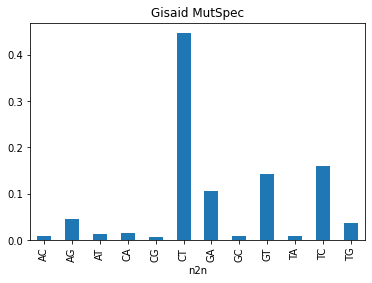

In [94]:
plt.figure(figsize=(6, 4))

mutspec.plot.bar()
plt.title('Gisaid MutSpec')
plt.show()

In [94]:
??????????
wrong annotation? check!

Object `????????` not found.


In [117]:
old_df = pd.read_csv('../data/past2/gisaid_sample_mutspec2.csv', index_col=0)

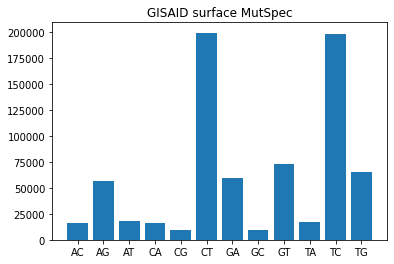

In [118]:
# plt.figure(figsize=(8, 4))
cols = ['A2C', 'A2G', 'A2T', 'C2A', 'C2G', 'C2T', 'G2A', 'G2C', 'G2T', 'T2A', 'T2C', 'T2G']
_ma = old_df[cols].sum(axis=0)
plt.bar(_ma.index, _ma)
plt.title("GISAID surface MutSpec")
plt.xticks(range(12), list(map(lambda s: s.replace("2", ""), cols)))
plt.show()